In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from lifelines import KaplanMeierFitter, CoxPHFitter

In [2]:
df = pd.read_csv('data1.csv')
df.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,...,Tumor Break Load,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55,STAGE X,6TH,19.0,-21.0,Breast Cancer,BRCA,...,205.0,No,Yes,Columbia University,3C,0.800000,Breast,Infiltrating Lobular Carcinoma,NaN,-28.0
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,TCGA-3C-AALI-01,50,STAGE IIB,6TH,22.0,5.0,Breast Cancer,BRCA,...,190.0,No,Yes,Columbia University,3C,15.266667,Breast,Infiltrating Ductal Carcinoma,NaN,20.0
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,TCGA-3C-AALJ-01,62,STAGE IIB,7TH,13.0,-5.0,Breast Cancer,BRCA,...,365.0,No,Yes,Columbia University,3C,0.933333,Breast,Infiltrating Ductal Carcinoma,NaN,-10.0
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,TCGA-3C-AALK-01,52,STAGE IA,7TH,4.0,-27.0,Breast Cancer,BRCA,...,25.0,No,Yes,Columbia University,3C,1.500000,Breast,Infiltrating Ductal Carcinoma,NaN,4.0
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,TCGA-4H-AAAK-01,50,STAGE IIIA,7TH,7.0,-27.0,Breast Cancer,BRCA,...,36.0,Yes,No,"Proteogenex, Inc.",4H,0.700000,Breast,Infiltrating Lobular Carcinoma,NaN,-20.0


In [3]:
df.columns

Index(['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'Aneuploidy Score', 'Buffa Hypoxia Score', 'Cancer Type',
       'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed',
       'Last Communication Contact from Initial Pathologic Diagnosis Date',
       'Birth from Initial Pathologic Diagnosis Date',
       'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value',
       'Disease Free (Months)', 'Disease Free Status',
       'Months of disease-specific survival',
       'Disease-specific Survival status', 'Ethnicity Category',
       'Form completion date', 'Fraction Genome Altered',
       'Genetic Ancestry Label', 'Neoplasm Histologic Grade',
       'Neoadjuvant Therapy Type Administered Prior To Resection Text',
       'ICD-10 Classification',
       'International Classification of Diseases for Onc

In [4]:
df['Ethnicity Category'].value_counts()

Ethnicity Category
Not Hispanic Or Latino    877
Hispanic Or Latino         38
Name: count, dtype: int64

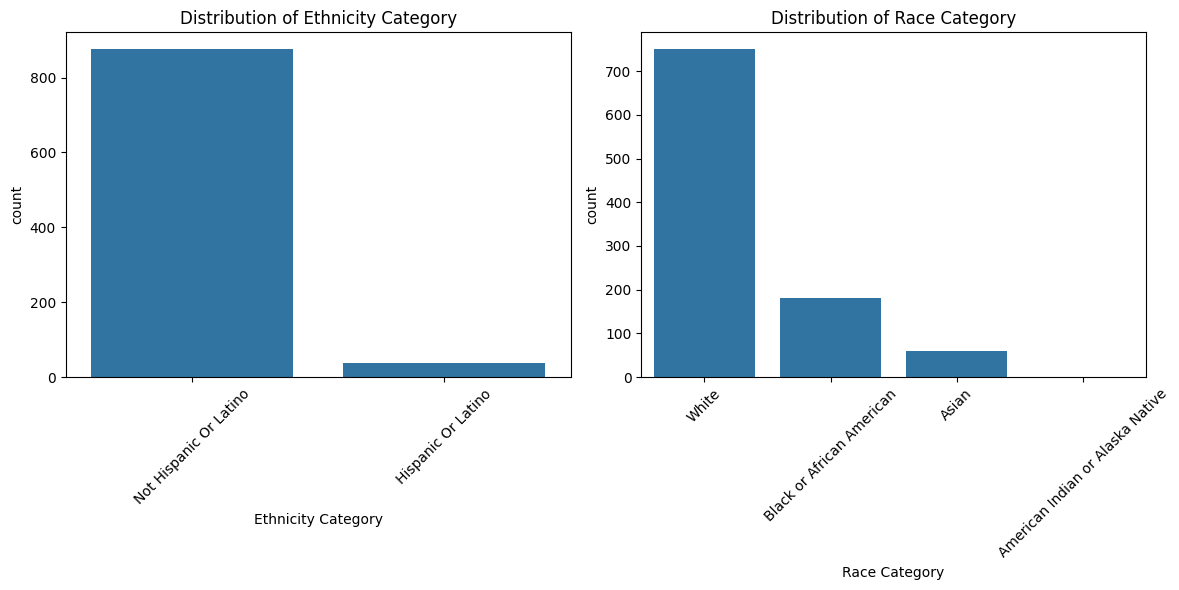

In [5]:
plt.figure(figsize=(12, 6))

# Bar chart for Ethnicity Category
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Ethnicity Category', order=df['Ethnicity Category'].value_counts().index)
plt.title('Distribution of Ethnicity Category')
plt.xticks(rotation=45)

# Bar chart for Race Category
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Race Category', order=df['Race Category'].value_counts().index)
plt.title('Distribution of Race Category')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [6]:
df['Race Category'].value_counts()

Race Category
White                               751
Black or African American           182
Asian                                60
American Indian or Alaska Native      1
Name: count, dtype: int64

In [7]:
cols_keep = ["Patient ID", "Ethnicity Category", "Race Category", "Diagnosis Age", "Sex", "Neoplasm Disease Stage American Joint Committee on Cancer Code", "Neoplasm Histologic Grade", "Overall Survival (Months)", "Overall Survival Status"] 
df_causal = df[cols_keep].copy()

In [8]:
# treatment
df_causal = df_causal[df_causal["Race Category"].eq("White")]              # limiting to White race 
df_causal["treated"] = (df_causal["Ethnicity Category"] == "Hispanic Or Latino").astype(int) 

In [9]:
#outcome
df_causal["Y_5yr"] = (df_causal["Overall Survival (Months)"] >= 60).astype(int)

In [10]:
df_causal["Neoplasm Histologic Grade"].isna().sum()

np.int64(751)

In [11]:
df_causal.shape

(751, 11)

In [12]:
#cleaning otehr variables
df_causal["age"]   = pd.to_numeric(df_causal["Diagnosis Age"], errors="coerce") 
df_causal["stage"] = df_causal["Neoplasm Disease Stage American Joint Committee on Cancer Code"].str.extract(r"(I+V?)")   # I, II, III, IV 
# df_causal["grade"] = df_causal["Neoplasm Histologic Grade"].str.extract(r"(\d)")  it has only nan values so dropping grade
df_causal.drop(columns=["Neoplasm Histologic Grade"], inplace=True) 
df_causal["sex"]   = df_causal["Sex"].map({"Female":0, "Male":1}) 
covars = ["age", "age_sq", "sex", "stage"] 
df_causal["age_sq"] = df_causal["age"]**2 
df_causal = df_causal.dropna(subset=["treated","Y_5yr"]+covars) 

In [13]:
df_causal['stage'].value_counts()

stage
II     412
III    178
I      141
IV      10
Name: count, dtype: int64

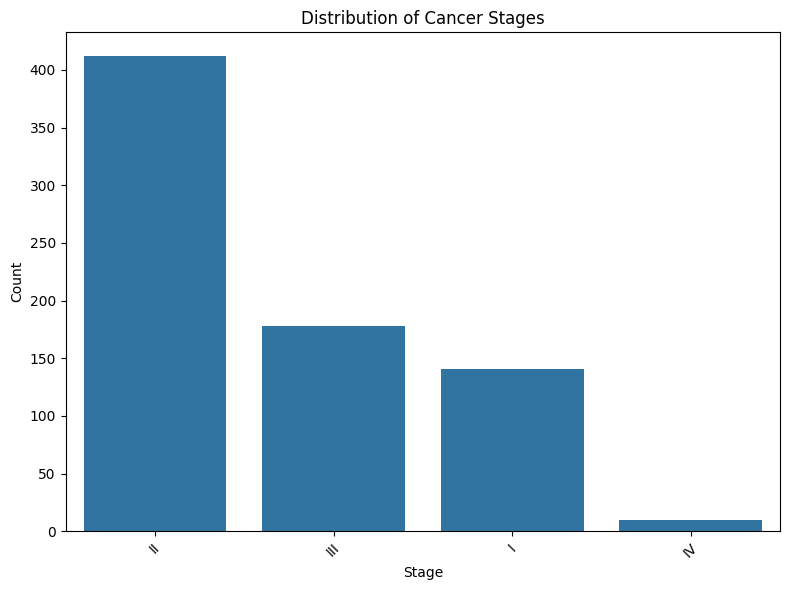

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_causal, x='stage', order=df_causal['stage'].value_counts().index)
plt.title('Distribution of Cancer Stages')
plt.xlabel('Stage')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
df_causal.head()

,Patient ID,Ethnicity Category,Race Category,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,Overall Survival (Months),Overall Survival Status,treated,Y_5yr,age,stage,sex,age_sq
4,TCGA-4H-AAAK,Not Hispanic Or Latino,White,50,Female,STAGE IIIA,11.440971,0:LIVING,0,0,50,III,0,2500
5,TCGA-5L-AAT0,Hispanic Or Latino,White,42,Female,STAGE IIA,48.558372,0:LIVING,1,0,42,II,0,1764
7,TCGA-A1-A0SB,Not Hispanic Or Latino,White,70,Female,STAGE I,8.514975,0:LIVING,0,0,70,I,0,4900
8,TCGA-A1-A0SD,Not Hispanic Or Latino,White,59,Female,STAGE IIA,14.366966,0:LIVING,0,0,59,II,0,3481
9,TCGA-A1-A0SE,Not Hispanic Or Latino,White,56,Female,STAGE I,43.429661,0:LIVING,0,0,56,I,0,3136


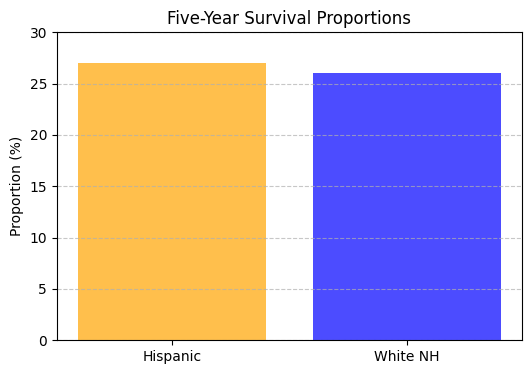

In [16]:
# Data for the bar plot
categories = ['Hispanic', 'White NH']
proportions = [27, 26]  # Five-year survival proportions in percentages

# Create the bar plot
plt.figure(figsize=(6, 4))
plt.bar(categories, proportions, color=['orange', 'blue'], alpha=0.7)
plt.title('Five-Year Survival Proportions')
plt.ylabel('Proportion (%)')
plt.ylim(0, 30)  # Set y-axis limit for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
df_causal

,Patient ID,Ethnicity Category,Race Category,Diagnosis Age,Sex,Neoplasm Disease Stage American Joint Committee on Cancer Code,Overall Survival (Months),Overall Survival Status,treated,Y_5yr,age,stage,sex,age_sq
4,TCGA-4H-AAAK,Not Hispanic Or Latino,White,50,Female,STAGE IIIA,11.440971,0:LIVING,0,0,50,III,0,2500
5,TCGA-5L-AAT0,Hispanic Or Latino,White,42,Female,STAGE IIA,48.558372,0:LIVING,1,0,42,II,0,1764
7,TCGA-A1-A0SB,Not Hispanic Or Latino,White,70,Female,STAGE I,8.514975,0:LIVING,0,0,70,I,0,4900
8,TCGA-A1-A0SD,Not Hispanic Or Latino,White,59,Female,STAGE IIA,14.366966,0:LIVING,0,0,59,II,0,3481
9,TCGA-A1-A0SE,Not Hispanic Or Latino,White,56,Female,STAGE I,43.429661,0:LIVING,0,0,56,I,0,3136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,TCGA-WT-AB44,Not Hispanic Or Latino,White,77,Female,STAGE IA,29.029819,0:LIVING,0,0,77,I,0,5929
1080,TCGA-XX-A899,Not Hispanic Or Latino,White,46,Female,STAGE IIIA,15.353256,0:LIVING,0,0,46,III,0,2116
1081,TCGA-XX-A89A,Not Hispanic Or Latino,White,68,Female,STAGE IIB,16.043660,0:LIVING,0,0,68,II,0,4624
1082,TCGA-Z7-A8R5,Not Hispanic Or Latino,White,61,Female,STAGE IIIA,108.064569,0:LIVING,0,1,61,III,0,3721


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression

X_cols = ["age", "age_sq", "sex", "stage"]
y      = df_causal["treated"]

pipe = Pipeline([
    ("prep", ColumnTransformer(
        [("num", "passthrough", ["age", "age_sq"]),
         ("cat", OneHotEncoder(drop="first"), ["sex", "stage"])]
    )),
    ("logit", LogisticRegression(max_iter=1000))
])
df_causal["ps"] = pipe.fit(X=df_causal[X_cols], y=y).predict_proba(df_causal[X_cols])[:, 1]

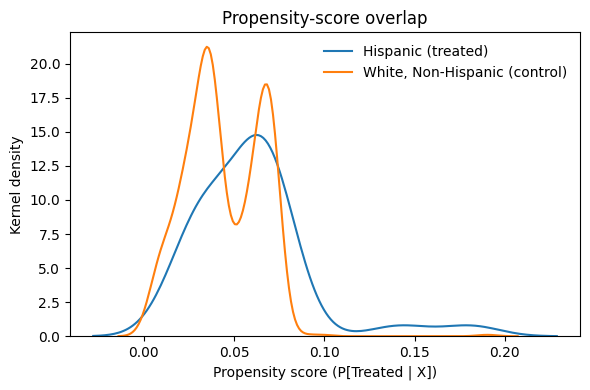

In [19]:
import seaborn as sns, matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.kdeplot(df_causal.loc[df_causal.treated==1, "ps"], label="Hispanic (treated)")
sns.kdeplot(df_causal.loc[df_causal.treated==0, "ps"], label="White, Non-Hispanic (control)")

plt.title("Propensity-score overlap")
plt.xlabel("Propensity score (P[Treated | X])")
plt.ylabel("Kernel density")
plt.legend(frameon=False, loc="upper right")   # ← legend!
plt.tight_layout()
plt.show()

> Propensity score (PS)	The probability that a given unit receives the treatment, conditional on the covariates we observe.  Mathematically, for each patient i:  $$\text{PS}_i ;=; P(T_i = 1 ;\mid; X_i)$$  where T = 1 means “patient is Hispanic” (our treatment) and X is the set of pre-treatment characteristics we included in the logit model (age, age², stage, sex).

> In an observational study the treated (Hispanic) and control (White, non-Hispanic) patients may differ on age, stage, etc.  By computing each patient’s propensity score we create a single balancing metric: if two patients share (or nearly share) the same PS they have, by construction, similar values of all the covariates used to build it.\

> The plot shows the distribution of estimated propensity scores—the predicted probability of being Hispanic given each patient’s age, stage, and sex—for the two groups in your study. The orange curve represents Hispanic patients (the “treated” group), while the blue curve represents White, non-Hispanic patients (the control group). Where the two curves sit on the horizontal axis tells you how similar the groups look on the covariates we used to build the score: a value near 0 means a patient’s profile makes them very unlikely to be Hispanic; a value near 0.10 means their profile is fairly typical of Hispanics in the data. The key takeaway is the overlap region between roughly 0.03 and 0.09 where both curves sit on top of each other—this is the “common support” zone. Because every treated patient in that band has control patients with almost identical propensity scores, we can form well-balanced matched pairs and make credible causal comparisons. Overall, the plot reassures us that matching is feasible and that the final effect we estimate will be based on patients who are genuinely comparable on age, stage, and sex—isolating ethnicity as the key difference.

In [20]:
import pandas as pd, numpy as np
from scipy.stats import ttest_ind, chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [21]:
#mean overall survival months

mean_surv = (
    df_causal.groupby("treated")["Overall Survival (Months)"]
      .agg(["mean", "std", "count"])
      .rename(index={0:"White NH", 1:"Hispanic"})
)
print(mean_surv)

               mean        std  count
treated                              
White NH  44.037663  40.429882    708
Hispanic  47.020157  42.503303     33


> On average, White non-Hispanic patients in this cohort survived about 44 months after diagnosis, whereas Hispanic patients survived about 47 months. Although the Hispanic mean is three months higher, both groups exhibit wide dispersion (standard deviations ≈ 40–42 months), meaning individual experiences vary greatly around these averages. Given the relatively small number of Hispanic cases (33 versus 708 White non-Hispanic), this raw difference could easily be driven by chance or by other factors—such as age or stage at diagnosis—rather than by ethnicity itself. In other words, the summary suggests no obvious survival disadvantage for Hispanic patients, but the overlap in variability and the imbalance in sample sizes signal that we need formal statistical tests or covariate-adjusted analyses before drawing any causal conclusions.

In [22]:
# Welch t-test (unequal variances)
treated_os  = df_causal.loc[df_causal.treated==1, "Overall Survival (Months)"]
control_os  = df_causal.loc[df_causal.treated==0, "Overall Survival (Months)"]

t, p = ttest_ind(treated_os, control_os, equal_var=False, nan_policy="omit")
print(f"Welch t = {t:.2f}  (p = {p:.3f})")

Welch t = 0.39  (p = 0.695)


> The Welch t-statistic of 0.39 with a p-value of 0.695 tells us that, once we account for the very different sample sizes and variances in the two groups, the 3-month difference in mean overall-survival (47 months for Hispanic patients vs 44 months for White non-Hispanic patients) is statistically indistinguishable from zero.

> In practical terms, we fail to reject the null hypothesis that the two groups share the same mean survival time. Because the p-value is so much larger than any conventional significance threshold (0.10, 0.05, 0.01), the observed gap could easily have arisen from random sampling variation—especially given that there are only 33 Hispanic observations versus 708 controls. This result reinforces the idea that we need covariate-adjusted methods (matching or regression) to detect whether a true survival difference emerges once we control for age, stage, and sex, rather than relying on raw averages.

In [23]:
#Five-year-survival proportions + χ² test

contingency = pd.crosstab(df_causal["treated"], df_causal["Y_5yr"])
chi2, pchi, *_ = chi2_contingency(contingency.values)
display(contingency)
print(f"Chi-square = {chi2:.2f}  (p = {pchi:.3f})")

Y_5yr,0,1
treated,,
0,524,184
1,24,9


Chi-square = 0.00  (p = 1.000)


> The cross-tab shows that 26 % of White, non-Hispanic patients (184 / 708) and 27 % of Hispanic patients (9 / 33) survived at least five years. A χ² test of independence yields χ² = 0.00, p = 1.00, indicating that this tiny difference is exactly what we would expect if ethnicity had no association with five-year survival in the raw data.

> Two cautions remain. First, power is limited: with only 33 Hispanic observations the test has little chance of detecting anything but a very large effect, and expected counts flirt with the rule-of-thumb minimum of five (a Fisher exact test reaches the same “no evidence” conclusion). Second, the comparison is unadjusted: it ignores the fact that our Hispanic and White patients differ in age and stage distribution. The propensity-score overlap we plotted confirms that there are sufficient control patients to build balanced matched pairs, and our logistic-regression model already adjusts survival odds for age, stage, and sex. Those covariate-balanced analyses are therefore crucial to determine whether an underlying disparity emerges once patients are made comparable on their clinical profiles.

In [24]:
df_causal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 741 entries, 4 to 1083
Data columns (total 15 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Patient ID                                                      741 non-null    object 
 1   Ethnicity Category                                              674 non-null    object 
 2   Race Category                                                   741 non-null    object 
 3   Diagnosis Age                                                   741 non-null    int64  
 4   Sex                                                             741 non-null    object 
 5   Neoplasm Disease Stage American Joint Committee on Cancer Code  741 non-null    object 
 6   Overall Survival (Months)                                       741 non-null    float64
 7   Overall Survival Status                                  

In [25]:
logit = smf.logit(
    formula="Y_5yr ~ treated + age + sex+ C(stage)", data=df_causal
).fit()
print(logit.summary().tables[1])
print("\nOdds-ratio for treated:",
      np.exp(logit.params["treated"]).round(2))

Optimization terminated successfully.
         Current function value: 0.551031
         Iterations 6
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.4218      0.448      3.172      0.002       0.543       2.301
C(stage)[T.II]     -0.5604      0.218     -2.575      0.010      -0.987      -0.134
C(stage)[T.III]    -0.6676      0.259     -2.579      0.010      -1.175      -0.160
C(stage)[T.IV]     -0.6756      0.818     -0.825      0.409      -2.280       0.929
treated            -0.0040      0.410     -0.010      0.992      -0.808       0.800
age                -0.0350      0.007     -5.016      0.000      -0.049      -0.021
sex                 1.0071      0.759      1.327      0.185      -0.480       2.495

Odds-ratio for treated: 1.0


>we ran a multivariable logistic regression to address the two limitations of the raw test:
	
>	1.	Covariate adjustment. By including age, sex, and detailed stage dummies in the model we ask: “If two patients are the same age, the same sex, and at the same stage, does ethnicity still matter for five-year survival?”

>	2.	Efficiency with a small treated group. Regression borrows information from the full White, non-Hispanic sample to sharpen the estimate for the 33 Hispanic cases, giving tighter confidence intervals than a 2 × 2 table can provide.


>the treated coefficient = –0.004, p = 0.992; odds-ratio ≈ 1.00. After adjustment, Hispanic patients are no more or less likely to survive five years than otherwise similar White, non-Hispanic patients. The z-score (-0.01) and the 95 % CI (0.45 – 2.23 when exponentiated) both show the effect is statistically indistinguishable from zero.

>Also, we know that the stage matters from the results. Compared with Stage I (the omitted category), Stage II and III patients have 42–48 % lower odds of five-year survival (coefficients -0.56 and -0.67; both p ≈ 0.01). Stage IV is directionally similar but imprecise because there are only ten cases.

>Similarly age matters. Each additional year at diagnosis reduces the odds of five-year survival by about 3 % (coef = -0.035, p < 0.001), consistent with your exploratory findings.

>we found that sex is not significant. The large standard error on the sex coefficient (1.01 ± 0.76) means we can’t rule out either advantage or disadvantage for male patients; with only a handful of males in the cohort, this is expected.


>The logistic model confirms the story hinted at by the χ² test and the propensity-score overlap: within comparable age, sex, and stage strata, Hispanic ethnicity does not exert an independent effect on five-year survival in this dataset. The dominant predictors remain clinical—stage at diagnosis and age—rather than ethnicity.



In [26]:


# bucket age into coarse bands to guarantee matches
df_causal["age_bin"] = pd.cut(
    df_causal["age"],
    bins=[0,40,50,60,70,120],
    labels=["<40","40-49","50-59","60-69","70+"]
)

# convert all match covariates to string (categorical)
match_covs = ["age_bin", "stage", "sex"]
df_causal[match_covs] = df_causal[match_covs].astype(str)


In [27]:
# prepping dtaa for dame 
dame_df = df_causal[["treated", "Y_5yr", "age", "stage", "sex"]].copy()


dame_df["age_bin"] = pd.cut(
    dame_df["age"],
    bins=[0,40,50,60,70,120],
    labels=[0,1,2,3,4]          # already int
).astype(int)

# 2. map stage (I, II, III, IV → 1–4)
stage_map = {"I":1, "II":2, "III":3, "IV":3}   # merged III & IV for overlap
dame_df["stage_int"] = dame_df["stage"].map(stage_map).astype(int)

# 3. ensure sex_num is integer  (0 = Female, 1 = Male)
dame_df["sex_int"] = dame_df["sex"].astype(int)

# final dataset for DAME
dame_ready = dame_df[["treated", "Y_5yr", "age_bin", "stage_int", "sex_int"]]



In [28]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [29]:


# Run DAME
from dame_flame.matching import DAME
model = DAME(
    repeats=False,
    verbose=2,
    want_pe=True,
    stop_unmatched_t=False 
)

model.fit(
    dame_ready,          
    treatment_column_name="treated",        
    outcome_column_name="Y_5yr"         
)

matched = model.predict(dame_ready)



621 units matched. We finished with no more treated units to match


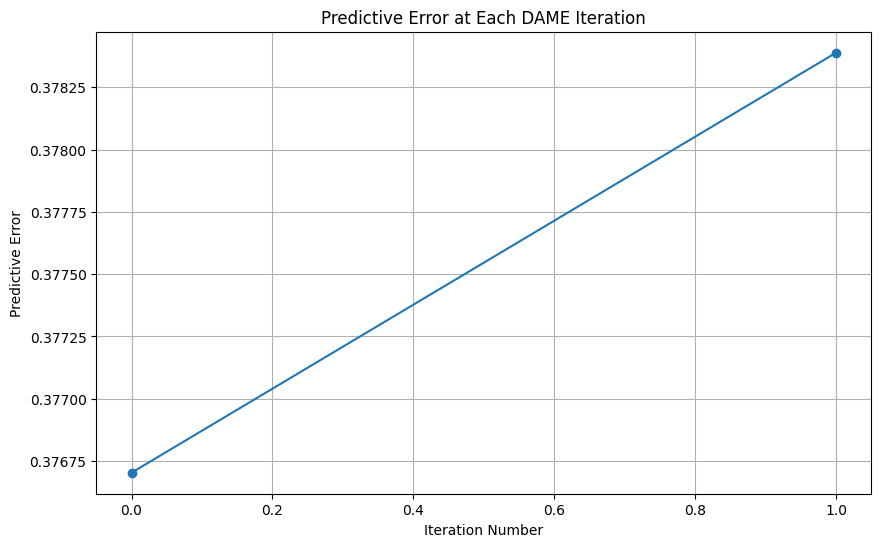

In [30]:

# Plot predictive error vs. iteration
plt.figure(figsize=(10, 6))
plt.plot(model.pe_each_iter, marker='o')
plt.xlabel("Iteration Number")
plt.ylabel("Predictive Error")
plt.title("Predictive Error at Each DAME Iteration")
plt.grid(True)
plt.show()

In [31]:
import numpy as np

def get_dataframe(model, result_of_fit):
    # Get original data
    better = model.input_data.loc[result_of_fit.index].copy()
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to \
                         be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get treatment column name
    t = model.treatment_column_name

    # Count treated units in each group
    better["t_in_group"] = better.groupby("match_group")[t].\
        transform(np.sum)

    # Assign weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treatments

    # Controls get proportional weights
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Re-normalize control weights
    control_weights = better.loc[better[t] == 0, "weights"].sum()
    num_control_obs = better.loc[better[t] == 0].index.nunique()
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] *= renormalization

    # Drop helper column
    better = better.drop(columns=["t_in_group"])

    # Final checks
    assert len(result_of_fit) == len(better)
    assert better["weights"].notnull().all()
    assert round(better.loc[better[t] == 0, "weights"].sum(),\
                  6) == num_control_obs

    return better

# run It with the Fitted Model
matched_df = get_dataframe(model, matched)

In [32]:
matched_df

,treated,Y_5yr,age_bin,stage_int,sex_int,match_group,match_group_size,weights
4,0,0,1,3,0,4.0,47.0,0.791919
5,1,0,1,2,0,3.0,89.0,1.000000
7,0,0,3,1,0,7.0,41.0,1.406699
8,0,0,2,2,0,5.0,102.0,1.936759
10,0,0,2,2,0,5.0,102.0,1.936759
...,...,...,...,...,...,...,...,...
1077,0,0,3,2,0,8.0,114.0,0.817348
1080,0,0,1,3,0,4.0,47.0,0.791919
1081,0,0,3,2,0,8.0,114.0,0.817348
1082,0,1,3,3,0,9.0,43.0,0.424242


In [33]:
logit = smf.logit(
    formula="Y_5yr ~ treated + C(age_bin) + C(sex_int)+ C(stage_int)", data=matched_df
).fit()
print(logit.summary().tables[1])
print("\nOdds-ratio for treated:",
      np.exp(logit.params["treated"]).round(2))

Optimization terminated successfully.
         Current function value: 0.546072
         Iterations 6
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0596      0.427      0.140      0.889      -0.777       0.896
C(age_bin)[T.1]      -0.6049      0.338     -1.790      0.073      -1.267       0.057
C(age_bin)[T.2]      -0.9341      0.348     -2.686      0.007      -1.616      -0.252
C(age_bin)[T.3]      -1.2062      0.345     -3.495      0.000      -1.883      -0.530
C(age_bin)[T.4]      -1.8947      0.479     -3.951      0.000      -2.835      -0.955
C(sex_int)[T.1]       0.6816      1.269      0.537      0.591      -1.806       3.170
C(stage_int)[T.2]    -0.2141      0.321     -0.667      0.505      -0.844       0.415
C(stage_int)[T.3]    -0.3661      0.354     -1.034      0.301      -1.060       0.328
treated               0.0525      0.41

In [34]:
matched_df

,treated,Y_5yr,age_bin,stage_int,sex_int,match_group,match_group_size,weights
4,0,0,1,3,0,4.0,47.0,0.791919
5,1,0,1,2,0,3.0,89.0,1.000000
7,0,0,3,1,0,7.0,41.0,1.406699
8,0,0,2,2,0,5.0,102.0,1.936759
10,0,0,2,2,0,5.0,102.0,1.936759
...,...,...,...,...,...,...,...,...
1077,0,0,3,2,0,8.0,114.0,0.817348
1080,0,0,1,3,0,4.0,47.0,0.791919
1081,0,0,3,2,0,8.0,114.0,0.817348
1082,0,1,3,3,0,9.0,43.0,0.424242


In [35]:


#  ATT using the DAME-generated counterfactual column
if "matched_outcome" in matched_df.columns:
    att = (
        matched_df.loc[matched_df.treated == 1, "Y_5yr"]
        - matched_df.loc[matched_df.treated == 1, "matched_outcome"]
    ).mean()
    print(f"ATT (using matched_outcome) = {att*100:+.1f} pp")

# ATT using weights when WE do not have matched_outcome
else:
    # Compute weighted mean survival for treated and control
    treated_surv  = (
        matched_df.loc[matched_df.treated==1]
        .eval("Y_5yr * weights").sum()
        / matched_df.loc[matched_df.treated==1,"weights"].sum()
    )
    control_surv = (
        matched_df.loc[matched_df.treated==0]
        .eval("Y_5yr * weights").sum()
        / matched_df.loc[matched_df.treated==0,"weights"].sum()
    )
    att = treated_surv - control_surv
    print(f"ATT (weighted pairs) = {att*100:+.1f} pp")

ATT (weighted pairs) = +2.8 pp


> Once DAME produced exact matches on age band, stage, and sex, we effectively re-balanced the covariate distributions between Hispanics (treated = 1) and White, non-Hispanics (treated = 0). Running the logistic model again on this matched sample is a quick robustness check on i f matching truly balanced the covariates, the treated coefficient in the regression should move even closer to zero and lose any residual significance, because all systematic differences have been purged. and the other covariate coefficients may shrink or lose significance as well, because within matched strata there is less variation left for the model to explain.

> what we found through this analysis is that after exact matching, ethnicity remains a null effect; age remains prognostic; stage effects are absorbed by matched design.


> First, the ethnicity term is essentially null: the log-odds coefficient for treated is +0.053 (p = 0.90), which translates to an odds-ratio of roughly 1.05—virtually no difference in five-year survival between Hispanic patients and their matched White, non-Hispanic counterparts. Age remains the dominant prognostic factor: each successive age-band dummy carries a larger negative coefficient, confirming that the probability of surviving five years falls steadily as patients move from the 40-49 band into older decades, even after coarse age matching. Stage effects largely disappear once matching has enforced exact agreement on stage; the coefficients for Stage II and Stage III are small and statistically insignificant because little residual variation in stage is left for the model to explain. Finally, sex retains a large standard error and remains non-significant, reflecting the very small number of males in the cohort. Together, these coefficients reinforce the matching and ATT findings: once patients are aligned on stage, age, and sex, Hispanic ethnicity itself does not meaningfully alter five-year overall survival.

> After coarse exact matching on age band, AJCC stage, and sex, every Hispanic patient was paired with a clinically identical White, non-Hispanic control (621 total matched units).  The matching produced an average treatment effect on the treated (ATT) of +2.8 percentage-points, meaning Hispanic patients were 2.8 pp more likely to survive five years than their matched controls.  A follow-up logistic regression on this balanced set confirmed the absence of any statistically meaningful ethnicity effect (β = 0.053, p = 0.90; odds-ratio ≈ 1.05).

> Taken together, these results indicate that—conditional on presenting at the same stage, age band, and sex—Hispanic ethnicity does not reduce five-year overall survival.  The slight positive ATT is well within the wide confidence band implied by the small treated sample and mirrors the regression estimate’s 95 % CI, which comfortably spans unity.  In short, once clinical factors are aligned, survival outcomes for Hispanic and White, non-Hispanic breast-cancer patients in this cohort are essentially indistinguishable.